# Inicjalizacja danych

In [515]:
import plotly.express as px
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

In [516]:
sns.set_context("paper")
sns.set(style="ticks")

CONST_LOCATION = "lokalizacja"
CONST_DISTANCE = "dystans [cm]"
CONST_PACKET_ERR_RATE = "PER [%]"
CONST_NODE_COUNT = "[ilość] węzłów"
CONST_PING_INTERVAL = "interwał zapytań [ms]"
CONST_LOCAL_PACKETS = "[ilość] wysłanych pakietów"
CONST_REMOTE_PACKETS = "[ilość] odebranych pakietów"

CONST_CAT_GROUND_TRUTH = "ground_truth"
CONST_CAT_CITY = "teren zurbanizowany"
CONST_CAT_FOREST = "teren leśny"

def compute_packet_error_rate(sent_packets_cnt, remote_received_packets_cnt):
    return (sent_packets_cnt - remote_received_packets_cnt) * 100.0 / sent_packets_cnt

def plot_catplot(data, env, title):
    data_by_location = data[data[CONST_LOCATION] == env]
    g = sns.catplot(x=CONST_DISTANCE, y=CONST_PACKET_ERR_RATE, hue=CONST_NODE_COUNT, col=CONST_PING_INTERVAL, data=data_by_location, kind="point", ci=68)
    g.figure.subplots_adjust(top=0.8)
    g.figure.suptitle(title)
    
def plot_at_ping(data, ping: int, title: str):
    data_at_ping = data[data[CONST_PING_INTERVAL] == ping]
    g = sns.catplot(x=CONST_DISTANCE, y=CONST_PACKET_ERR_RATE, hue=CONST_LOCATION, col=CONST_NODE_COUNT, kind="point", ci=68, data=data_at_ping)
    g.figure.subplots_adjust(top=0.8)
    g.figure.suptitle(title)
    
def plot_all_at_condition(data, condition, title, **params):
    data = data[condition]
    # g = sns.catplot(x=CONST_DISTANCE, y=CONST_PACKET_ERR_RATE, kind="point", ci=68, data=data, legend_out=True, linestyles=['solid', 'dashed', 'dashdot', 'dotted'], markers=['v', 'H', 's', 'D'], **params)
    # g.figure.subplots_adjust(top=0.9)
    # g.figure.suptitle(title)
    # for ax in g.axes.flat:
    #     ax.grid(True, axis='both')
        
    g = sns.lmplot(x=CONST_DISTANCE, y=CONST_PACKET_ERR_RATE, data=data, ci=68, x_estimator=np.mean, **params)
    g.figure.subplots_adjust(top=0.9)
    g.figure.suptitle(title)
    for ax in g.axes.flat:
        ax.grid(True, axis='both')

In [517]:
data = pd.read_csv("results.csv")

In [518]:
std_results= []
# data["local_sent_packets"] += 1 # - do naprawienia błąd systemowy
data.rename(columns={
    "node_count": CONST_NODE_COUNT,
    "ping_interval": CONST_PING_INTERVAL,
    "distance_cm": CONST_DISTANCE,
    "local_sent_packets": CONST_LOCAL_PACKETS,
    "remote_received_packets": CONST_REMOTE_PACKETS,
    "location": CONST_LOCATION
}, inplace=True)
data[CONST_PACKET_ERR_RATE] = compute_packet_error_rate(data[CONST_LOCAL_PACKETS], data[CONST_REMOTE_PACKETS])

for node in pd.unique(data[CONST_NODE_COUNT]):
    data_node = data[data[CONST_NODE_COUNT] == node]
    for env in pd.unique(data_node[CONST_LOCATION]):
        data_env = data_node[data_node[CONST_LOCATION] == env]
        for interval in pd.unique(data_env[CONST_PING_INTERVAL]):
            data_interval = data_env[data_env[CONST_PING_INTERVAL] == interval]
            for distance in pd.unique(data_interval[CONST_DISTANCE]):
                data_distance = data_interval[data_interval[CONST_DISTANCE] == distance]
                stats = data_distance[CONST_PACKET_ERR_RATE]
                stats_mean = stats.mean()
                stats_std = stats.std()
                std_results.append({"node": node, "env": env, "interval_ms": interval, "distance_cm": distance, "mean_per": stats_mean, "std_per": stats_std})
                # print(f"node={node}@{env} {interval}ms {distance}cm mean={stats_mean} std={stats_std}")
df_results = pd.DataFrame(std_results)
df_results.tail()

,node,env,interval_ms,distance_cm,mean_per,std_per
123,2,teren zurbanizowany,2100,800,15.555556,16.850834
124,2,teren zurbanizowany,2100,1000,28.888889,32.010801
125,2,teren zurbanizowany,2100,1300,20.000000,27.666444
126,2,teren zurbanizowany,2100,1600,6.666667,14.907120
127,2,teren zurbanizowany,2100,2100,55.555556,41.573971


In [519]:
# data_city = df_results[df_results["env"] == "city"]
# data_forest = df_results[df_results["env"] == "forest"]
# data_ground_truth = df_results[df_results["env"] == "ground_truth"]
# data_forest_n2 = data_forest[df_results["node"] == 2]

# f = sns.relplot(data=data_forest_n2.pivot("distance_cm", "interval_ms", "mean_per"), kind="line", markers=True)
# f.set_titles("Forest, 2 nodes")
# import matplotlib.pyplot as plt
# g = sns.FacetGrid(data_forest_n2, col="interval_ms")
# g.map(plt.errorbar, "distance_cm", "mean_per", "std_per", marker="o")

# sns.catplot(x="distance_cm", y="mean_per", hue="interval_ms", data=data_forest_n2, col="interval_ms", kind="point")
# sns.lineplot(x="distance_cm", y="mean_per", hue="interval_ms", data=data_forest_n2, markers=True)

# Przegląd danych względem lokalizacji

## Struktura danych

In [520]:
data.tail()

,[ilość] węzłów,interwał zapytań [ms],dystans [cm],[ilość] wysłanych pakietów,[ilość] odebranych pakietów,lokalizacja,PER [%]
635,2,2100,2100,9,8,teren zurbanizowany,11.111111
636,2,2100,2100,9,0,teren zurbanizowany,100.000000
637,2,2100,2100,9,0,teren zurbanizowany,100.000000
638,2,2100,2100,9,6,teren zurbanizowany,33.333333
639,2,2100,2100,9,6,teren zurbanizowany,33.333333


## Pomiary - miasto

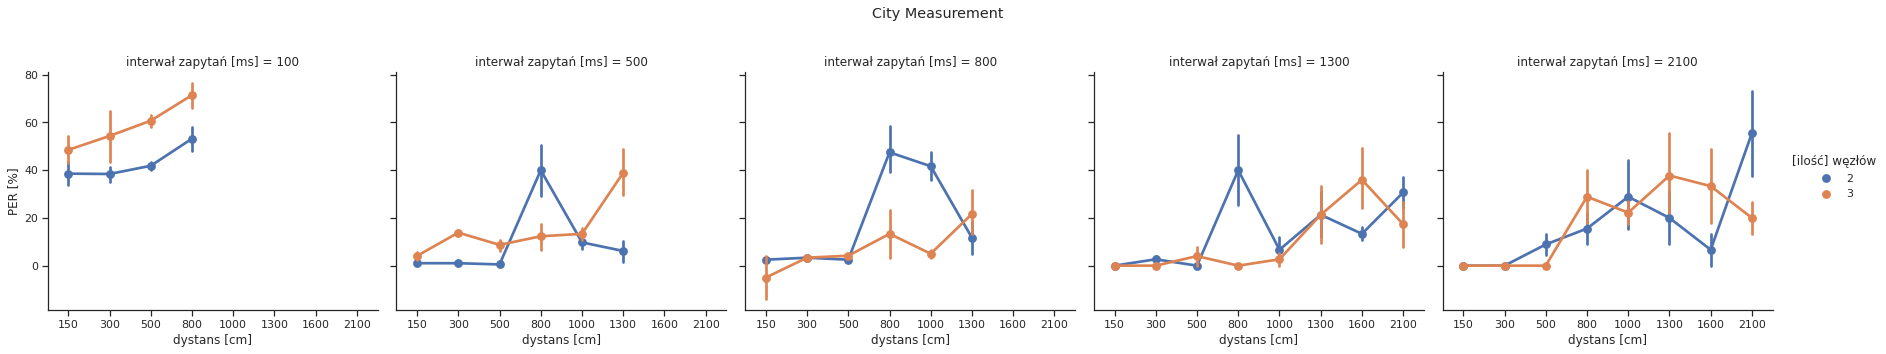

In [521]:
plot_catplot(data, CONST_CAT_CITY, "City Measurement")

## Pomiary - las

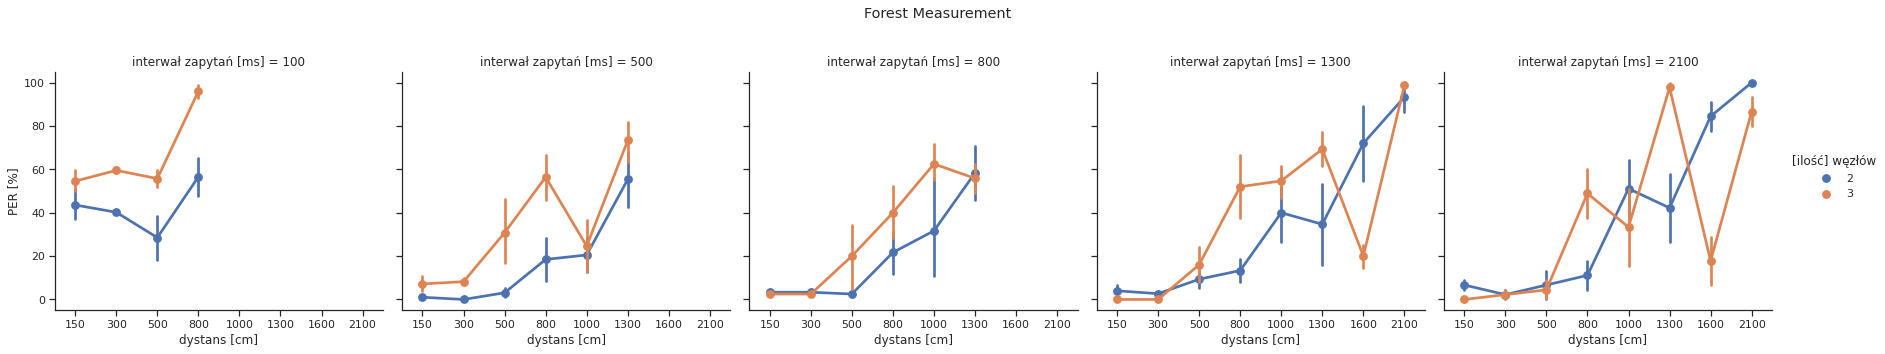

In [522]:
plot_catplot(data, CONST_CAT_FOREST, "Forest Measurement")

# Przegląd danych - porównanie ilości węzłów dla PER względem czasu pingowania

## Ping = 100ms

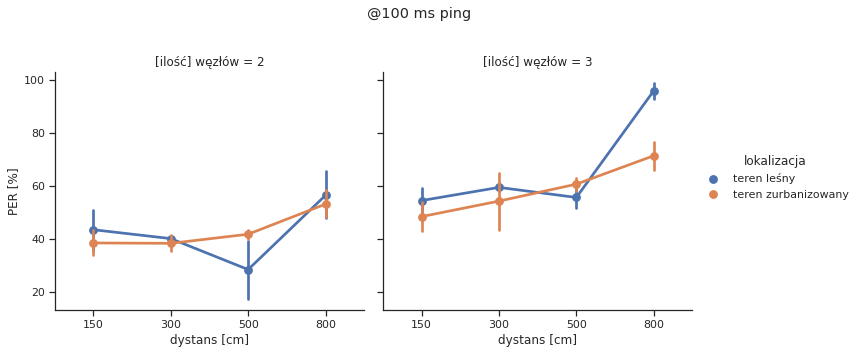

In [523]:
plot_at_ping(data, 100, "@100 ms ping")

Pomimo bliskiej wzajemnej obecności węzłów, dostrzega się błędy PER. Wynikają one nie tyle z samej właściwości BLE, co z samej stosu BLE Mesh wykorzystywanego do badań. Przy dużej ilości zdarzeń, mikrokontroler traci stabilność, gubiąc komunikaty/przepełniając bufory. Mikrokontroler w tej sytacji wymagał również restartów.

## Ping = 500ms

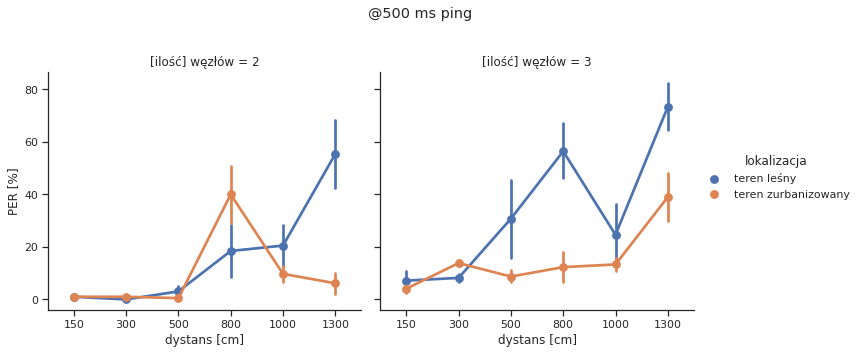

In [524]:
plot_at_ping(data, 500, "@500 ms ping")

## Ping = 800ms

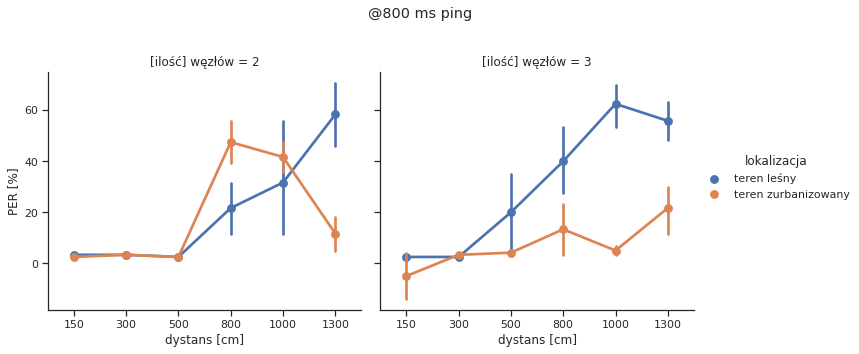

In [525]:
plot_at_ping(data, 800, "@800 ms ping")

## Ping = 1300ms

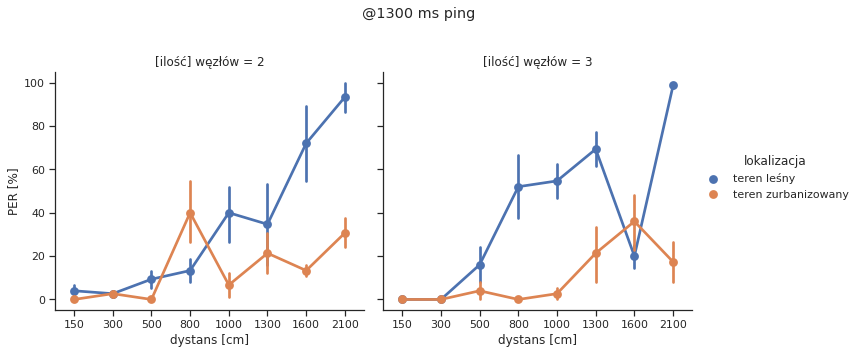

In [526]:
plot_at_ping(data, 1300, "@1300 ms ping")

## Ping = 2100ms

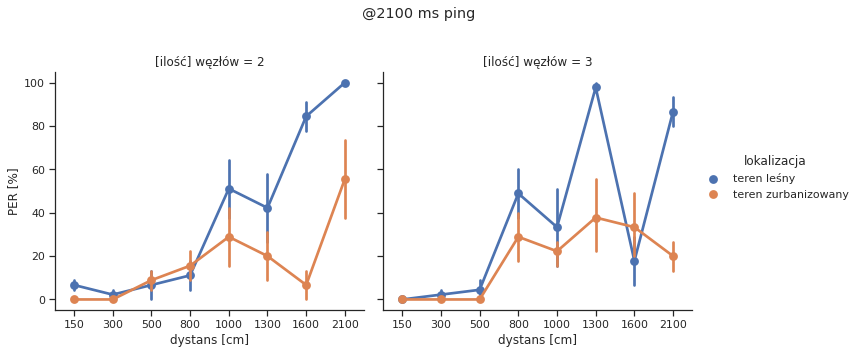

In [527]:
plot_at_ping(data, 2100, "@2100 ms ping")

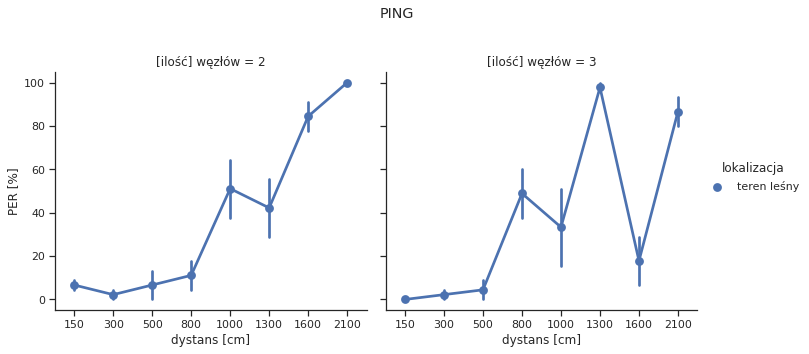

In [528]:
plot_at_ping(data[(data[CONST_PING_INTERVAL]==2100)&(data[CONST_LOCATION] == CONST_CAT_FOREST)], 2100, "PING")

# Analiza danych

## Zależność Packet Error Rate względem częstości zapytań

### ≤ 100ms

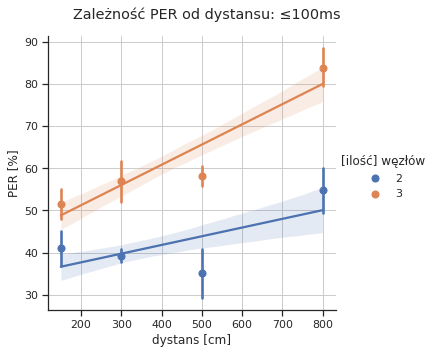

In [529]:
plot_all_at_condition(data, ((data[CONST_PING_INTERVAL] == 100) & (data[CONST_LOCATION] != CONST_CAT_GROUND_TRUTH)), "Zależność PER od dystansu: ≤100ms", hue=CONST_NODE_COUNT)

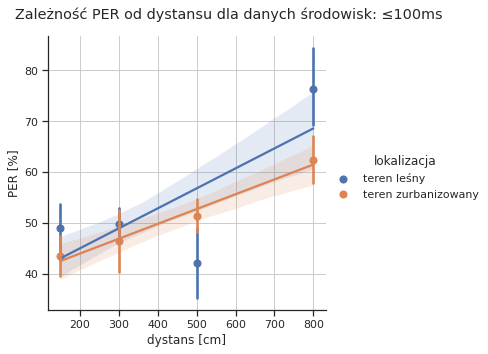

In [530]:
plot_all_at_condition(data, data[CONST_PING_INTERVAL] == 100, "Zależność PER od dystansu dla danych środowisk: ≤100ms", hue=CONST_LOCATION)

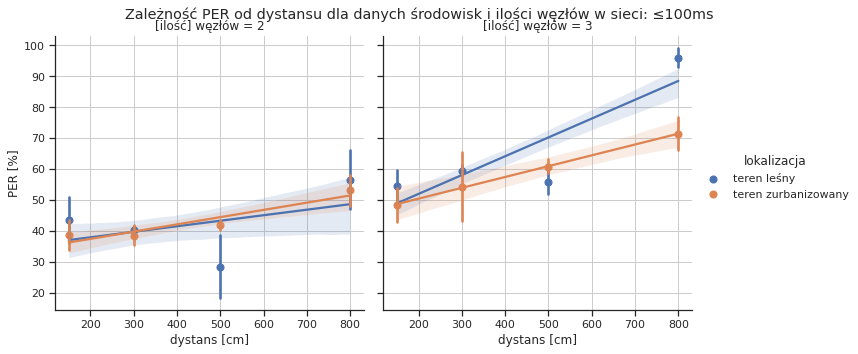

In [531]:
plot_all_at_condition(data, data[CONST_PING_INTERVAL] == 100, "Zależność PER od dystansu dla danych środowisk i ilości węzłów w sieci: ≤100ms", hue=CONST_LOCATION, col=CONST_NODE_COUNT)

### >100ms

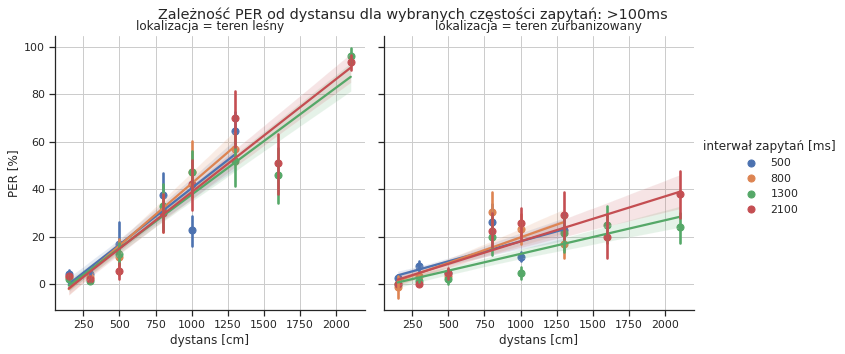

In [532]:
plot_all_at_condition(data, ((data[CONST_PING_INTERVAL] > 100)&(data[CONST_LOCATION] != CONST_CAT_GROUND_TRUTH)), "Zależność PER od dystansu dla wybranych częstości zapytań: >100ms", hue=CONST_PING_INTERVAL, col=CONST_LOCATION)

Może zbadanie korelacji pomiędzy różnicami w PER? Zdaje się, że zmienna PING INTERVAL nie wpływa na PER

## Zależność Packet Error Rate względem odległości między węzłami

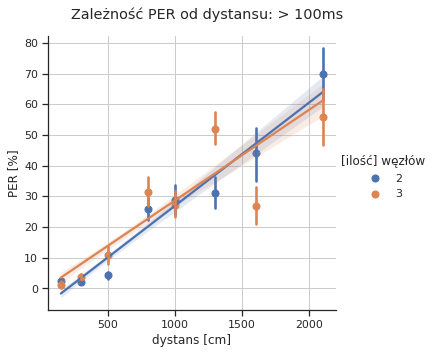

In [533]:
plot_all_at_condition(data, ((data[CONST_PING_INTERVAL] > 100) & (data[CONST_LOCATION] != CONST_CAT_GROUND_TRUTH)), "Zależność PER od dystansu: > 100ms", hue=CONST_NODE_COUNT)

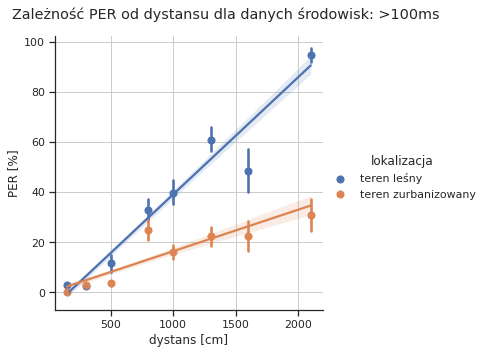

In [534]:
plot_all_at_condition(data, data[CONST_PING_INTERVAL] > 100, "Zależność PER od dystansu dla danych środowisk: >100ms", hue=CONST_LOCATION)

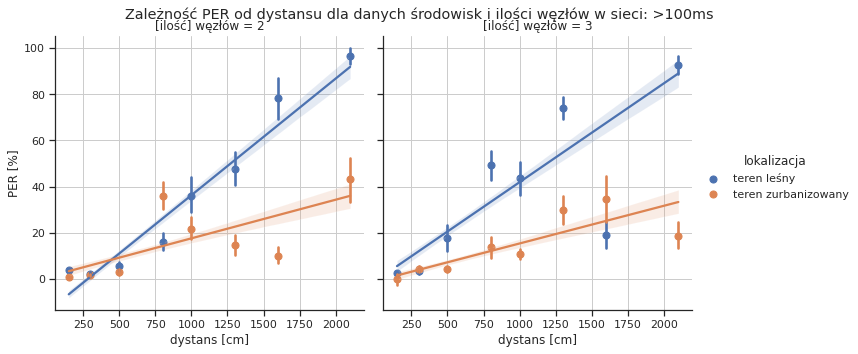

In [535]:
plot_all_at_condition(data, data[CONST_PING_INTERVAL] > 100, "Zależność PER od dystansu dla danych środowisk i ilości węzłów w sieci: >100ms", hue=CONST_LOCATION, col=CONST_NODE_COUNT)

# Szkice

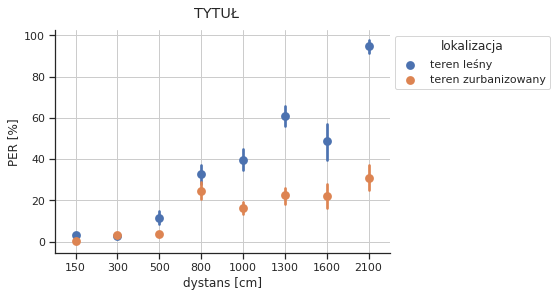

In [536]:
sns.set_theme(style="white")
sns.axes_style("darkgrid")
data2 = data[data[CONST_PING_INTERVAL] > 100]
g = sns.pointplot(x=CONST_DISTANCE, y=CONST_PACKET_ERR_RATE, ci=68, data=data2, hue=CONST_LOCATION, col=CONST_NODE_COUNT, linestyles="none")
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle("TYTUŁ")

g.spines.right.set_visible(False)
g.spines.top.set_visible(False)
g.yaxis.set_ticks_position('left')
g.xaxis.set_ticks_position('bottom')
g.grid(visible=True)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

# g.axhline(linewidth=1.6, color="black")
# g.axvline(linewidth=1.6, color="black")
# g.plot(1, 0, ">k", transform=g.get_yaxis_transform(), clip_on=False)
# g.plot(0, 1, "^k", transform=g.get_xaxis_transform(), clip_on=False)

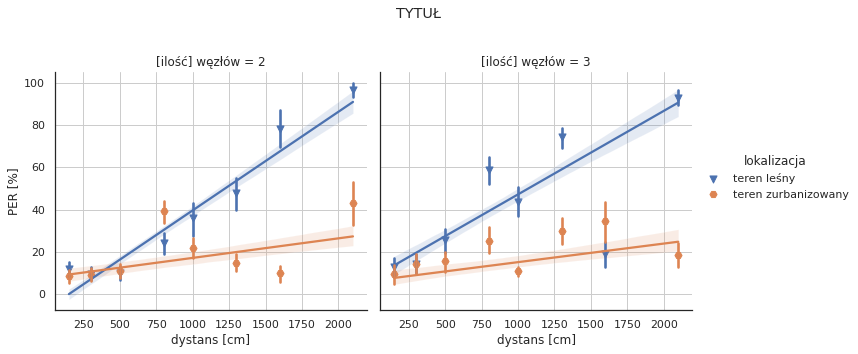

In [541]:
# sns.set_style("ticks",{'axes.grid' : True})

# sns.set_context("paper")
# sns.set(style="ticks") ['solid', 'dashed', 'dashdot', 'dotted']
g = sns.lmplot(x=CONST_DISTANCE, y=CONST_PACKET_ERR_RATE, data=data, hue=CONST_LOCATION, col=CONST_NODE_COUNT, markers=['v', 'H'], ci=68, x_estimator=np.mean, robust=True)
g.figure.subplots_adjust(top=0.8)
g.figure.suptitle("TYTUŁ")
for ax in g.axes.flat:
    ax.grid(True, axis='both')

# g.spines.right.set_visible(False)
# g.spines.top.set_visible(False)
# g.yaxis.set_ticks_position('left')
# g.xaxis.set_ticks_position('bottom')
# g.grid(visible=True)
# sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

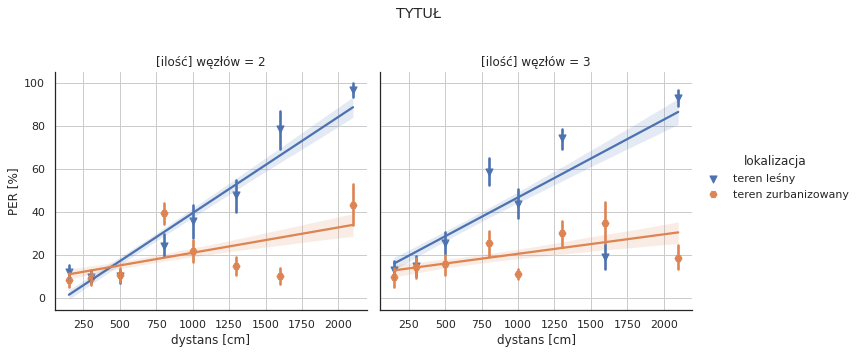

In [538]:
# plot_all_at_condition(data, ((data[CONST_PING_INTERVAL] == 100) & (data[CONST_LOCATION] != CONST_CAT_GROUND_TRUTH)), "Zależność PER od dystansu: ≤100ms", hue=CONST_NODE_COUNT)
g = sns.lmplot(x=CONST_DISTANCE, y=CONST_PACKET_ERR_RATE, data=data, hue=CONST_LOCATION, col=CONST_NODE_COUNT, markers=['v', 'H'], ci=68, x_estimator=np.mean)
g.figure.subplots_adjust(top=0.8)
g.figure.suptitle("TYTUŁ")
for ax in g.axes.flat:
    ax.grid(True, axis='both')
    

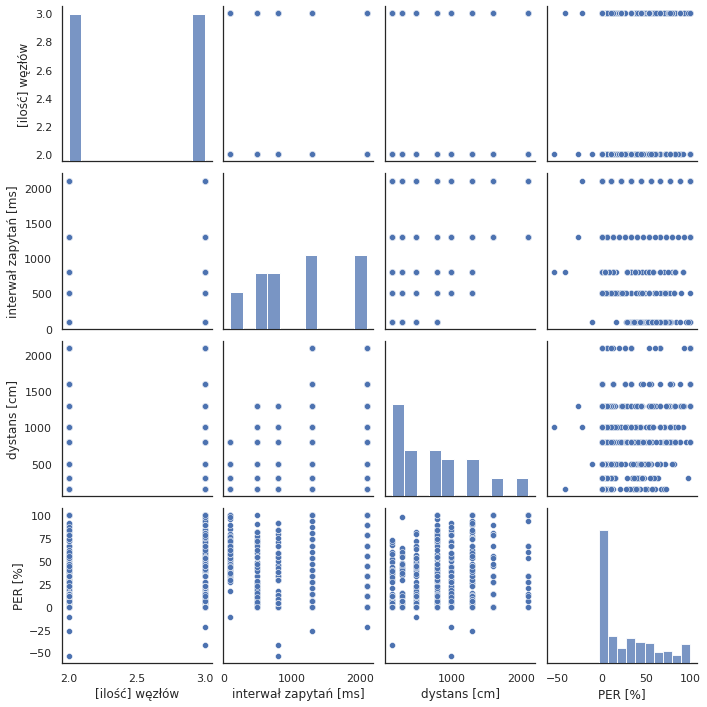

In [539]:
per_only_data = data.drop(CONST_LOCAL_PACKETS, inplace=False, axis=1)
per_only_data = per_only_data.drop(CONST_REMOTE_PACKETS, inplace=False, axis=1)
sns.pairplot(per_only_data)